**Name: Nidhi Rajkumar Saini<br>
USC ID: 3730422872**

## Import required libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from bs4 import BeautifulSoup

import contractions
from nltk.corpus import stopwords
nltk.download('stopwords', quiet = True)
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.linear_model import Perceptron
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings('ignore')

In [2]:
#! pip install bs4 # in case you don't have it installed

# Dataset: https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Kitchen_v1_00.tsv.gz

## Read Data

- Used pandas read_csv method to read the Amazon reviews dataset .gz file into a pandas dataframe. The compression parameter for this method is set to infer by default, which can automatically infer the kind of files i.e gzip , zip , bz2 , xz from the file extension.
- error_bad_lines is used to drop lines with too many fields (e.g. a csv line with too many commas).
- warn_bad_lines is used to supress the logs showing skipped lines.
- pandas.DataFrame.head method returns the first n rows of the dataframe.

In [3]:
df = pd.read_csv('https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Kitchen_v1_00.tsv.gz', sep="\t", error_bad_lines = False, warn_bad_lines = False)
df.head(3)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,37000337,R3DT59XH7HXR9K,B00303FI0G,529320574,Arthur Court Paper Towel Holder,Kitchen,5.0,0.0,0.0,N,Y,Beautiful. Looks great on counter,Beautiful. Looks great on counter.,2015-08-31
1,US,15272914,R1LFS11BNASSU8,B00JCZKZN6,274237558,Olde Thompson Bavaria Glass Salt and Pepper Mi...,Kitchen,5.0,0.0,1.0,N,Y,Awesome & Self-ness,I personally have 5 days sets and have also bo...,2015-08-31
2,US,36137863,R296RT05AG0AF6,B00JLIKA5C,544675303,Progressive International PL8 Professional Man...,Kitchen,5.0,0.0,0.0,N,Y,Fabulous and worth every penny,Fabulous and worth every penny. Used for clean...,2015-08-31


## Keep Reviews and Ratings

- Selected only the required Reviews and Ratings fields from the input dataframe and renamed them as 'reviews' and 'ratings' respectively.
- Used pandas.DataFrame.sample method to return a random sample of n rows of the dataframe.

In [4]:
selected_df = df[['star_rating', 'review_body']].rename(columns={'star_rating': 'ratings', 'review_body':'reviews'})
# Include three sample reviews in your report along with corresponding ratings. 
selected_df.sample(n = 3)

,ratings,reviews
3764510,5.0,Not much to say here other than it works. Our ...
2264428,5.0,Very stylish and useful.
4253177,3.0,"this does work, but it is made cheap for the p..."


## Statistics of each rating class

- Calculated statistics of ratings by taking an aggregated count after grouping the dataframe by column 'ratings'.
- Plotted a bar chart to visualize the results.

         reviews
ratings         
1.0       426870
2.0       241939
3.0       349539
4.0       731701
5.0      3124595


<AxesSubplot:xlabel='ratings'>

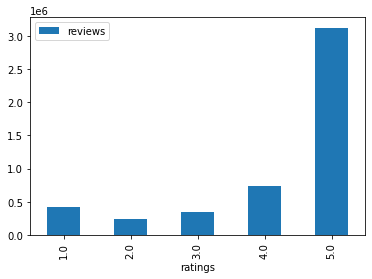

In [5]:
# Report the statistics of the ratings, i.e., how many reviews received 1 ratings, etc.
stats_df = selected_df.groupby(selected_df['ratings']).agg('count')
print(stats_df)
stats_df.plot.bar(y='reviews')

# Labelling Reviews:
## The reviews with rating 4,5 are labelled to be 1 and 1,2 are labelled as 0. Discard the reviews with rating 3'

- Created function label_review to return labels according to the ratings as asked by the problem statement.
- Used pandas.DataFrame.apply method to apply label_review function to each row of the 'ratings' column and get labels.
- Used pandas.DataFrame.assign method to assign new column 'label' to the dataframe with values returned by the pandas.DataFrame.apply method.

In [6]:
def label_review(row):
    if row['ratings'] == 4 or row['ratings'] == 5:
        return 1
    elif row['ratings'] == 1 or row['ratings'] == 2:
        return 0
    else:
        return -1

In [7]:
col = selected_df.apply(label_review, axis = 1) # get column data with an index
selected_df = selected_df.assign(label = col.values) # assign values to column 'label'
selected_df

,ratings,reviews,label
0,5.0,Beautiful. Looks great on counter.,1
1,5.0,I personally have 5 days sets and have also bo...,1
2,5.0,Fabulous and worth every penny. Used for clean...,1
3,5.0,A must if you love garlic on tomato marinara s...,1
4,5.0,Worth every penny! Buy one now and be a pizza ...,1
...,...,...,...
4874885,4.0,"After a month of heavy use, primarily as a chi...",1
4874886,5.0,I've used my Le Creuset enameled cast iron coo...,1
4874887,4.0,"According to my wife, this is \\""the best birt...",1
4874888,4.0,Hoffritz has a name of producing a trendy and ...,1


In [8]:
selected_df = selected_df[['reviews','label']]

## Statistics for the 3 classes

- -1 : ratings == 3
- 0 : ratings < 3
- 1 : ratings > 3
- Calculated statistics of label by taking an aggregated count after grouping the dataframe by column 'label'.
- Plotted a bar chart to visualize the results. 

label
-1     349539
 0     668809
 1    3856296
Name: reviews, dtype: int64


<AxesSubplot:xlabel='label'>

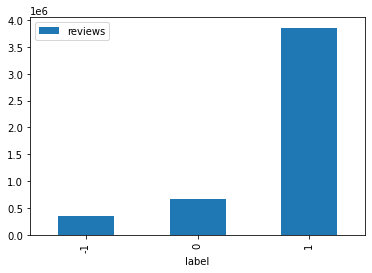

In [9]:
# Include the number of reviews for each of these three classes in your report.
stats_df = selected_df.groupby(selected_df['label']).agg('count')
print(stats_df['reviews'])
stats_df.plot.bar(y='reviews')

 ## We select 200000 reviews randomly with 100,000 positive and 100,000 negative reviews.



- Used pandas.DataFrame.sample method to return a random sample of n rows of the dataframe for both positive and negative reviews.
- Then, concatenated both positive and negative reviews dataframe into one dataframe using pandas.concat method.
- Used pandas.DataFrame.sample method with option frac = 1 to shuffle the dataframe randomly and hence avoid rows being sequentially ordered for positive and negative reviews.
- Also used pandas.DataFrame.reset_index with option drop = True to reset the index of the dataframe with default integer index.

In [10]:
selected_df_1 = selected_df[selected_df['label'] == 1].sample(n = 100000) # positive reviews
selected_df_0 = selected_df[selected_df['label'] == 0].sample(n = 100000) # negative reviews

In [11]:
merged_df = pd.concat([selected_df_0, selected_df_1])
merged_df = merged_df.sample(frac = 1).reset_index(drop = True)
merged_df

,reviews,label
0,I am astounded by all these positive reviews! ...,0
1,Was looking for replacement &#34;kid&#34; size...,0
2,"The best of the best! Very stylish, modern, co...",1
3,$239 a pair?!?! Are you kidding?!?! CrystalC...,0
4,Works like a charm! Definitely the most used ...,1
...,...,...
199995,I love this plate and the stand it comes with....,1
199996,"The first time I ever used it,it broke. It's a...",0
199997,Works great! Does seem to get cloudy inside ea...,1
199998,My kids love them. I don't have problems with...,1


## Average length of reviews (Before Cleaning)

- Calculated the average length of reviews by using the len method to get the character length of each review and then taking the mean of the same, by using the pandas.DataFrame.mean method.
- Used pandas.DataFrame.apply method to apply above function to each row of the 'reviews' column.

In [12]:
# print the average length of the reviews in terms of character length in your dataset before cleaning
merged_df['reviews'].apply(lambda x: len(str(x))).mean()

321.99652

## 3 sample reviews (Before Data Cleaning + Preprocessing)

- Used pandas.DataFrame.sample method to return a random sample of n rows of the dataframe.

In [13]:
# Print three sample reviews before data cleaning + preprocessing
merged_df.sample(n = 3)

,reviews,label
159567,Returned. Could not chop an onion - it bent th...,0
136041,"My first Pitcher was awesome, only problem was...",0
191107,Do not buy this kettle. Very bad quality and t...,0


# Data Cleaning

## Convert all the reviews into the lower case.

- Used str.lower() method to convert all reviews into lower case.
- Used pandas.DataFrame.apply method to apply above function to each row of the 'reviews' column.

In [14]:
merged_df['reviews'] = merged_df['reviews'].apply(lambda x: str(x).lower())
# Dataframe after converting to lower case
merged_df

,reviews,label
0,i am astounded by all these positive reviews! ...,0
1,was looking for replacement &#34;kid&#34; size...,0
2,"the best of the best! very stylish, modern, co...",1
3,$239 a pair?!?! are you kidding?!?! crystalc...,0
4,works like a charm! definitely the most used ...,1
...,...,...
199995,i love this plate and the stand it comes with....,1
199996,"the first time i ever used it,it broke. it's a...",0
199997,works great! does seem to get cloudy inside ea...,1
199998,my kids love them. i don't have problems with...,1


## Remove the HTML and URLs from the reviews

- Used BeautifulSoup to remove the HTML tags as it is a Python package that creates a parse tree for parsed pages that can be used to extract data from HTML.
- Used regular expressions to identify and remove any URLs from the reviews.
- Used pandas.DataFrame.apply method to apply above functions to each row of the 'reviews' column.

In [15]:
def remove_html(string):
    soup = BeautifulSoup(string, "html.parser")
    return soup.get_text()

In [16]:
def remove_urls(string):
    result = re.sub(r'http\S+', '', string)
    return result

In [17]:
# removing the HTML and URLs from the reviews
merged_df['reviews'] = merged_df['reviews'].apply(lambda x: remove_html(str(x)))
merged_df['reviews'] = merged_df['reviews'].apply(lambda x: remove_urls(x))

## Remove non-alphabetical characters

- Used regular expressions to identify and remove non-alphabetical characters from the reviews(except spaces so that we can differentiate between words).
- Used pandas.DataFrame.apply method to apply above function to each row of the 'reviews' column in the dataframe.

In [18]:
def remove_nonalphachars(string):
    result = re.sub(r'[^a-zA-Z\s]','',string)
    return result

In [19]:
# Identifying rows with non-alphabetical characters in reviews
df_check = merged_df[merged_df.reviews.str.contains('[^a-zA-Z\s]', regex = True, na = False)]
idx_nonalpha = df_check.index.tolist()
df_check

,reviews,label
0,i am astounded by all these positive reviews! ...,0
1,"was looking for replacement ""kid"" sized straws...",0
2,"the best of the best! very stylish, modern, co...",1
3,$239 a pair?!?! are you kidding?!?! crystalc...,0
4,works like a charm! definitely the most used ...,1
...,...,...
199995,i love this plate and the stand it comes with....,1
199996,"the first time i ever used it,it broke. it's a...",0
199997,works great! does seem to get cloudy inside ea...,1
199998,my kids love them. i don't have problems with...,1


In [20]:
# Saving indices of reviews having contractions to test later
df_contractions = merged_df[merged_df.reviews.str.contains('\'', regex = True, na = False)]
idx_contractions = df_check[:10].index.tolist()

In [21]:
# removing the non-alphabetical characters from the reviews
merged_df['reviews'] = merged_df['reviews'].apply(remove_nonalphachars)
merged_df.loc[idx_nonalpha]

,reviews,label
0,i am astounded by all these positive reviews ...,0
1,was looking for replacement kid sized straws f...,0
2,the best of the best very stylish modern comfo...,1
3,a pair are you kidding crystalclassicscom s...,0
4,works like a charm definitely the most used a...,1
...,...,...
199995,i love this plate and the stand it comes with ...,1
199996,the first time i ever used itit broke its a ve...,0
199997,works great does seem to get cloudy inside eas...,1
199998,my kids love them i dont have problems with t...,1


## Remove the extra spaces between the words

- Used regular expressions to identify and remove extra spaces between the words.
- Used pandas.DataFrame.apply method to apply above function to each row of the 'reviews' column in the dataframe.

In [22]:
def remove_extra_space(string):
    result = re.sub(r'\s+',' ',string)
    return result

In [23]:
# removing extra spaces from the reviews
merged_df['reviews'] = merged_df['reviews'].apply(remove_extra_space)

## Perform contractions on the reviews.

- Used contractions library to perform contractions on the reviews and then expand them by applying contractions.fix method to each word in the review sentence.
- Used pandas.DataFrame.apply method to apply above function to each row of the 'reviews' column in the dataframe.

In [24]:
def contraction_function(review):
    contraction_str = []
    for word in review.split(' '):
        contraction_str.append(contractions.fix(word))
    return ' '.join(contraction_str)

In [25]:
# Before removing contractions from the reviews
df_contractions[:10]

,reviews,label
0,i am astounded by all these positive reviews! ...,0
5,i paid a lot of money for the lg. zero water c...,0
6,"i had this set, until the handles started brea...",0
7,it cost them about fifty cents to manufacture ...,0
8,i bought this coffee maker to replace another ...,1
9,i picked this up at the start of summer. i've ...,1
13,i ordered the red and blue la jolla stacks. t...,1
19,i need this for cooking class and it work grea...,1
24,"works when it works, but there's a piece under...",0
32,it is absolutely perfect for me! i've been sea...,1


In [26]:
# After removing contractions from the reviews
merged_df['reviews'] = merged_df['reviews'].apply(contraction_function)
merged_df.loc[idx_contractions]

,reviews,label
0,i am astounded by all these positive reviews i...,0
1,was looking for replacement kid sized straws f...,0
2,the best of the best very stylish modern comfo...,1
3,a pair are you kidding crystalclassicscom sel...,0
4,works like a charm definitely the most used an...,1
5,i paid a lot of money for the lg zero water co...,0
6,i had this set until the handles started break...,0
7,it cost them about fifty cents to manufacture ...,0
8,i bought this coffee maker to replace another ...,1
9,i picked this up at the start of summer I have...,1


## Average length of reviews (After Cleaning)

- Calculated the average length of reviews by using the len method to get the character length of each review and then taking the mean of the same, by using the pandas.DataFrame.mean method.
- Used pandas.DataFrame.apply method to apply above function to each row of the 'reviews' column.

In [27]:
# print the average length of the reviews in terms of character length in your dataset after cleaning
merged_df['reviews'].apply(lambda x: len(str(x))).mean()

306.713615

# Pre-processing

## Remove the stop words 

- Used nltk.corpus.stopwords package to remove all stop words from the reviews.
- Used nltk.tokenize.word_tokenize to tokenize the sentence into words and then checked if each word was a stop word and removed the stop words.

In [28]:
stopword = set(stopwords.words('english'))
def remove_stop_words(string):
    text_tokens = word_tokenize(string)
    tokens_without_sw = [word for word in text_tokens if not word in stopword]
    filtered_sentence = (" ").join(tokens_without_sw)
    return filtered_sentence

In [29]:
# Identifying stop words
merged_df.head(3)

,reviews,label
0,i am astounded by all these positive reviews i...,0
1,was looking for replacement kid sized straws f...,0
2,the best of the best very stylish modern comfo...,1


In [30]:
# Removing stop words from the reviews
merged_df['reviews'] = merged_df['reviews'].apply(remove_stop_words)
merged_df.head(3)

,reviews,label
0,astounded positive reviews go put together fli...,0
1,looking replacement kid sized straws toss take...,0
2,best best stylish modern comfortable use,1


## Perform lemmatization  

- Used nlkt.stem.WordNetLemmatizer to apply lemmatization on the reviews.

In [31]:
# Dataframe without lemmatization
df_check = merged_df[merged_df.reviews.str.contains('[.*s]', regex = True, na = False)]
idx_lm = df_check.index.tolist()
df_check

,reviews,label
0,astounded positive reviews go put together fli...,0
1,looking replacement kid sized straws toss take...,0
2,best best stylish modern comfortable use,1
3,pair kidding crystalclassicscom sells pair pos...,0
4,works like charm definitely used useful item k...,1
...,...,...
199995,love plate stand comes looks gorgeous kitchen ...,1
199996,first time ever used itit broke weak metal,0
199997,works great seem get cloudy inside easily hard...,1
199998,kids love problems leaking great colors great ...,1


In [32]:
lemmatizer = WordNetLemmatizer()
merged_df['reviews'] = merged_df['reviews'].apply(lambda x: ' '.join(map(lemmatizer.lemmatize, str(x).split(' '))))
# Dataframe after applying lemmatization
merged_df.loc[idx_lm]

,reviews,label
0,astounded positive review go put together flim...,0
1,looking replacement kid sized straw toss take ...,0
2,best best stylish modern comfortable use,1
3,pair kidding crystalclassicscom sell pair poss...,0
4,work like charm definitely used useful item ki...,1
...,...,...
199995,love plate stand come look gorgeous kitchen wi...,1
199996,first time ever used itit broke weak metal,0
199997,work great seem get cloudy inside easily hard ...,1
199998,kid love problem leaking great color great price,1


## 3 sample reviews (After Data Cleaning + Preprocessing)

In [33]:
# Print three sample reviews after data cleaning + preprocessing
merged_df.sample(n = 3)

,reviews,label
78558,bought bos always drinking cold coffee spilled...,0
47749,bought wedding tassel white different color da...,0
132770,bit concerned buying using pressure cooker I h...,1


# TF-IDF Feature Extraction

- Used sklearn.feature_extraction.text.TfidfVectorizer to extract TF-IDF features from the dataframe.

In [34]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(merged_df['reviews'].tolist())
X

<200000x123747 sparse matrix of type '<class 'numpy.float64'>'
	with 4876721 stored elements in Compressed Sparse Row format>

In [35]:
print(X)

  (0, 101756)	0.13179614987844374
  (0, 43675)	0.1448567267770488
  (0, 78443)	0.14390472686177763
  (0, 122269)	0.15404666303332962
  (0, 80209)	0.24079329140860511
  (0, 115379)	0.1709384880672713
  (0, 59574)	0.1482114860496413
  (0, 44836)	0.12506688754016745
  (0, 50431)	0.17730120282551065
  (0, 101688)	0.15935863907067788
  (0, 25048)	0.27749485188101536
  (0, 116088)	0.26302901668500533
  (0, 22043)	0.24912078163892912
  (0, 121954)	0.12776529235377573
  (0, 97256)	0.12296668809133751
  (0, 37921)	0.19228707218401006
  (0, 81681)	0.1266240032324518
  (0, 1436)	0.1984954808746291
  (0, 52)	0.30695132085958976
  (0, 60016)	0.17469736431190996
  (0, 95952)	0.19053349279593082
  (0, 43944)	0.08760403610018937
  (0, 48152)	0.1288378460994497
  (0, 40440)	0.15559483012596312
  (0, 110386)	0.15324392628225256
  :	:
  (199998, 62037)	0.2520286541370574
  (199998, 45770)	0.43573676141520185
  (199998, 57414)	0.43082927193896586
  (199999, 12385)	0.332893375081968
  (199999, 51424)	0.191

## Splitting the dataset into Train and Test

- Used sklearn.model_selection.train_test_split to split the dataset into training and testing dataset. 

In [36]:
# Split your dataset into 80% training dataset and 20% testing dataset.
X_train, X_test, y_train, y_test = train_test_split(X, merged_df['label'].to_numpy().reshape(-1, 1), train_size = 0.8, random_state = 42)

In [37]:
print("Train size (features):",X_train.shape)
print("Test size (features):",X_test.shape)
print("Train size (label):",y_train.shape)
print("Test size: (label):",y_test.shape)

Train size (features): (160000, 123747)
Test size (features): (40000, 123747)
Train size (label): (160000, 1)
Test size: (label): (40000, 1)


## Function to compute metrics

- Created function that uses accuracy_score, precision_score, recall_score and f1_score methods from sklearn.metrics module to get the metrics.

In [38]:
def compute_scores(text, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1score = f1_score(y_true, y_pred)
    print("{} Metrics:\nAccuracy = {}\nPrecision = {}\nRecall = {}\nF1-score = {}\n".format(text, accuracy, precision, recall, f1score))

# Perceptron

- Used sklearn.linear_model.Perceptron to train a Perceptron model on the training dataset.

In [39]:
model = Perceptron()
model.fit(X_train, y_train.ravel())

# make a prediction
ytrain_pred = model.predict(X_train)
ytest_pred = model.predict(X_test)

#calculate metrics
compute_scores("Train", y_train, ytrain_pred)
compute_scores("Test", y_test, ytest_pred)

Train Metrics:
Accuracy = 0.916625
Precision = 0.9293057968217204
Recall = 0.9020070690796458
F1-score = 0.9154529667515939

Test Metrics:
Accuracy = 0.853075
Precision = 0.8656227239621267
Recall = 0.834746400441479
F1-score = 0.849904226790959



# SVM

- Used sklearn.svm.LinearSVC to train a SVM model on the training dataset with max_iter set to 10000 i.e. increased the number of iterations to help the model to converge. 
- Used sklearn.preprocessing.StandardScaler to standardize features by removing the mean and scaling to unit variance, with option with_mean = False as we are dealing with features of type sparse matrices.
- Used sklearn.pipeline.make_pipeline to construct a pipeline for the given estimators.

In [40]:
clf = make_pipeline(StandardScaler(with_mean=False), LinearSVC(max_iter=10000))
clf.fit(X_train, y_train.ravel())

# make a prediction
ytrain_pred = clf.predict(X_train)
ytest_pred = clf.predict(X_test)

#calculate metrics
compute_scores("Train", y_train, ytrain_pred)
compute_scores("Test", y_test, ytest_pred)

Train Metrics:
Accuracy = 0.94975625
Precision = 0.9486943087810227
Recall = 0.9510285136198434
F1-score = 0.9498599771722249

Test Metrics:
Accuracy = 0.845025
Precision = 0.8422206717831158
Recall = 0.8478402648873727
F1-score = 0.8450211255281382



# Logistic Regression

- Used sklearn.linear_model.LogisticRegression to train a Logistic Regression model on the training dataset.

In [41]:
clf = LogisticRegression(max_iter = 500).fit(X_train, y_train.ravel())

# make a prediction
ytrain_pred = clf.predict(X_train)
ytest_pred = clf.predict(X_test)

#calculate metrics
compute_scores("Train", y_train, ytrain_pred)
compute_scores("Test", y_test, ytest_pred)

Train Metrics:
Accuracy = 0.9153125
Precision = 0.9188780715122357
Recall = 0.9112118600671937
F1-score = 0.9150289089837332

Test Metrics:
Accuracy = 0.8945
Precision = 0.8981805281029851
Recall = 0.8890784126824863
F1-score = 0.8936062928600241



# Naive Bayes

- Used sklearn.naive_bayes.MultinomialNB to train a Multinomial Naive Bayes model on the training dataset.

In [42]:
clf = MultinomialNB().fit(X_train, y_train.ravel())
ytrain_pred = clf.predict(X_train)
ytest_pred = clf.predict(X_test)

#calculate metrics
compute_scores("Train", y_train, ytrain_pred)
compute_scores("Test", y_test, ytest_pred)

Train Metrics:
Accuracy = 0.8897
Precision = 0.9017855993408602
Recall = 0.8748672986373912
F1-score = 0.8881225276397201

Test Metrics:
Accuracy = 0.8688
Precision = 0.8793593386721777
Recall = 0.8538604324487031
F1-score = 0.8664223172469966



In [43]:
# !pip install nbconvert

In [44]:
# !jupyter nbconvert --Application.log_level=CRITICAL --to pdf "C:/Users/saini/OneDrive/Documents/Courses/CSCI 544 (Natural Language Processing)/Homeworks/HW1"